In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy

import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old

import mu_avg.mu_avg as mu_avg

Welcome to JupyROOT 6.12/04


In [2]:
def probe_uncertainties(interp_df):
    interp_df = interp_df[['tr'+str(i) for i in range(17)]]
    probe_uncs = []
    for probe in range(17):
        diffs = np.diff(interp_df['tr'+str(probe)])
        diffs = diffs - np.polyval(np.polyfit(range(len(diffs)), diffs, 2), range(len(diffs)))
        probe_uncs.append(np.std(diffs))
    probe_uncs = np.array(probe_uncs)
    
    return probe_uncs

def multipole(order, skew, strength, x_pos, y_pos):
    """Returns the magnitude of a B-field given multipole parameters
    and position.
    """
    # Takes a multipole strength A normalized to 4.5 cm
    r_pos = np.sqrt(x_pos**2 + y_pos**2)
    theta = np.arctan2(y_pos, x_pos)
    if skew == 0:
        b_magnitude = strength * (r_pos/4.5)**order * np.cos(order*theta)
    if skew == 1:
        b_magnitude = strength * (r_pos/4.5)**order * np.sin(order*theta)
    return b_magnitude

all_ns =    [0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 7, 8, 10, 12]
all_skews = [0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]

def calc_chi2s_single(interp_df, probe_uncs, pos=0, order=1):
    
    interp_df = interp_df[['tr'+str(tr) for tr in range(17)]]
    meas = interp_df.iloc[pos].values
    chi2s = []
    
    instance_ns = [all_ns[0], all_ns[order]]
    instance_skews = [all_skews[0], all_skews[order]]
    
    for fit_order in range(1,3):
        ns = instance_ns[0:fit_order]
        skews = instance_skews[0:fit_order]

        mults = np.array([multipole(ns[i], skews[i], 1, trfp.TR_X, trfp.TR_Y) for i in range(fit_order)])
        mults[np.abs(mults) < 1.0e-9] = 0

        theta_tr = np.linalg.pinv(np.transpose(mults))
        theta_tr[np.abs(theta_tr) < 1.0e-9] = 0

        # run a set of trolley probe measurements through the matrix
        
        fit_coeffs = np.matmul(theta_tr, meas)

        fit_values = np.zeros(17)
        for i in range(fit_order):
            fit_values += multipole(ns[i], skews[i], fit_coeffs[i], trfp.TR_X, trfp.TR_Y)

        resids = meas - fit_values

        probe_uncs = np.full(17, 3)

        chi2 = 0
        for i in range(17):
            chi2 += resids[i]**2/probe_uncs[i]**2

        chi2s.append(chi2)
    
    chi2s = np.array(chi2s)
    dof = np.array([17 - m for m in range(1,3)])
    dof_Nm1 = np.array([17 - m - 1 for m in range(1,2)])
    F_chi = (chi2s[:-1] - chi2s[1:])/(chi2s[1:]/dof_Nm1)
    
    return chi2s, dof, F_chi[0]

def calc_chi2s_sequential(interp_df, probe_uncs, pos=0, through=16):
    
    interp_df = interp_df[['tr'+str(tr) for tr in range(17)]]
    meas = interp_df.iloc[pos].values
    chi2s = []

    for fit_order in range(1,through+1):

        # make a theta_tr matrix using only a set number of multipoles

        ns = all_ns[0:fit_order]
        skews = all_skews[0:fit_order]

        mults = np.array([multipole(ns[i], skews[i], 1, trfp.TR_X, trfp.TR_Y) for i in range(fit_order)])
        mults[np.abs(mults) < 1.0e-9] = 0

        theta_tr = np.linalg.pinv(np.transpose(mults))
        theta_tr[np.abs(theta_tr) < 1.0e-9] = 0

        # run a set of trolley probe measurements through the matrix
        
        fit_coeffs = np.matmul(theta_tr, meas)

        fit_values = np.zeros(17)
        for i in range(fit_order):
            fit_values += multipole(ns[i], skews[i], fit_coeffs[i], trfp.TR_X, trfp.TR_Y)

        resids = meas - fit_values

        probe_uncs = np.full(17, 3)

        chi2 = 0
        for i in range(17):
            chi2 += resids[i]**2/probe_uncs[i]**2

        chi2s.append(chi2)
    
    chi2s = np.array(chi2s)
    dof = np.array([17 - m for m in range(1,through+1)])
    dof_Nm1 = np.array([17 - m - 1 for m in range(1,through)])
    F_chi = (chi2s[:-1] - chi2s[1:])/(chi2s[1:]/dof_Nm1)
    
    return chi2s, dof, F_chi

print 'Functions defined.'

Functions defined.


Read in a stationary trolley run. Use the full run to estimate the uncertainty in the probe measurements by looking at the differences between subsequent measurements.

In [5]:
mults = np.array([multipole(all_ns[i], all_skews[i], 1, trfp.TR_X, trfp.TR_Y) for i in range(len(all_ns))])
mults[np.abs(mults) < 1.0e-9] = 0

theta_tr_all = np.linalg.pinv(np.transpose(mults))
theta_tr_all[np.abs(theta_tr_all) < 1.0e-9] = 0

test_m = np.matmul(theta_tr_all, np.transpose(mults))
test_m[np.abs(test_m) < 1.0e-4] = 0

# print 'If the multipole functions are properly defined, the following should be the 17x17 identity matrix.\n'
# print np.round(test_m,2)

In [3]:
interp_df = pd.read_hdf('hdf5/calibration_region.h5', 'tr_df')
probe_uncs = probe_uncertainties(interp_df)

In [6]:
print probe_uncs
print '\n'
print np.matmul(theta_tr_all, interp_df[['tr'+str(tr) for tr in range(17)]].iloc[500].values)

[14.39917243 18.05522719 13.81186296 14.74386239 12.1434747  24.91718762
 21.46406709 16.12787123 12.67501166 12.72551533 26.25674085 18.8731963
 15.88041055 13.27510659 10.09888067 13.00527022 30.76568953]


[ 5.18142117e+04 -3.83846718e+00 -1.01916600e+02  6.58310718e+00
  4.15783291e+01  1.46110599e+02 -2.61578006e+01 -4.12227241e+02
 -1.35157590e+02  6.59845703e+01 -1.08452953e+03 -7.04402264e+01
 -1.57159089e+02 -1.73904921e+03  1.05810979e+03  1.26294892e+01
 -2.80197080e+02]


In [7]:
skew_labels = ['norm', 'skew']

print "After fitting just a dipole, incorporating a single other moment in the fit yields:\n"
for order in range(1,17):
    _, _, F_chi = calc_chi2s_single(interp_df, probe_uncs, pos=500, order=order)
    print skew_labels[all_skews[order]] + ' ' + str(2*all_ns[order]+2) + '-pole: F = ' + str(F_chi)

After fitting just a dipole, incorporating a single other moment in the fit yields:

norm 4-pole: F = 0.010092929657313798
skew 4-pole: F = 12.193080271913812
skew 6-pole: F = 0.014760296037532403
norm 6-pole: F = 0.6898904408342396
skew 8-pole: F = 6.78263507833021
norm 8-pole: F = 0.1440082667117723
norm 10-pole: F = 0.076082920295111
skew 10-pole: F = 2.6812024517743716
norm 12-pole: F = 0.0644100158329466
skew 12-pole: F = 0.09039949014074877
norm 14-pole: F = 0.4642682402632269
norm 16-pole: F = 0.06410693327695627
skew 16-pole: F = 0.08257991796410542
norm 18-pole: F = 0.07817150328445291
norm 22-pole: F = 0.6655134581272172
norm 26-pole: F = 0.024078463819288787


[10755.1395684  10747.90770996  5925.42056317  5914.84769748
  5441.94012645  2250.29143678  2149.06071134  2094.78385237
   463.85933473   418.21842409   360.28049654    35.9771207
    35.89503045    25.84340451    19.36764523    19.3399492 ]
[672.19622302 716.52718066 423.24432594 454.98828442 453.49501054
 204.5719488  214.90607113 232.75376137  57.98241684  59.74548916
  60.04674942   7.19542414   8.97375761   8.61446817   9.68382261
  19.3399492 ]
[1.00929297e-02 1.13940976e+01 2.32376658e-02 1.04280656e+00
 1.56015950e+01 4.71046373e-01 2.33194337e-01 2.81279154e+01
 7.63922286e-01 9.64880333e-01 4.50707796e+01 9.14781227e-03
 1.16683070e+00 6.68719321e-01 1.43206287e-03]


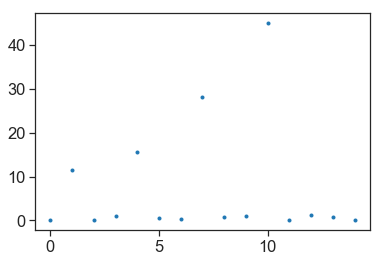

In [8]:
chi2s, dof, F_chi = calc_chi2s_sequential(interp_df, probe_uncs, pos=500)

print chi2s
print chi2s/dof
print F_chi

plt.plot(F_chi, '.')